# Init

In [1]:
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path
import json
%cd ..
%load_ext autoreload

c:\Users\kepes\Projects\segmentation


In [31]:
%autoreload 2
from src.MapData import MapData, min_max_dist, triangle_corr, get_triangular_kernel
from src.LineFinder import LineFinder

from src.plotting_functions import plot_embedding, plot_single_variable_map

# Data

In [40]:
map_data = MapData(
    './data/2022_03_22_P56B_307x532.libsdata',
    overwrite=False
)
map_data.get_metadata()
map_data.load_wavelenths()
map_data.load_all_data('preprocessed')
# map_data.load_all_data('trial')
# map_data.spectra = map_data.spectra[:200,:]
map_data.get_map_dimensions()

map_data.trim_spectra(64)
map_data.estimate_systemic_noise()

map_data.get_baseline(
    min_window_size=50,
    smooth_window_size=100
)
map_data.baseline_correct()

map_data.upsample_spectra()
if map_data.systemic_noise_spectrum is not None:
    map_data.denoise_spectra(
        file_name_supplement='preprocessed',
        threshold=np.std(map_data.systemic_noise_spectrum)
    )

maxima_spectrum = map_data.spectra.max(axis=0)

loading metadata
loading wavelengths
loading raw data
getting map dimensions
estimating systemic noise spectrum
getting baselines
upsampling spectra
denoising spectra


In [33]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=map_data.wvl,
        # y=map_data.spectra[0,:]
        y=maxima_spectrum
    )
)

## Line finding

In [ ]:
# for bin in bins:
#     plt.scatter(
#         x=bin,
#         y=np.std(maxima_spectrum[maxima_spectrum <= bin + bin_half_width])
#     )

In [34]:
line_finder = LineFinder(
    maxima_spectrum,
    map_data.wvl,
    name='maxima'
)
line_finder.find_lines(
    # height=bins[2],
    # threshold=None,
    # distance=None,
    # prominence=bins[1],
    # width=7,
    # wlen=35,
    # rel_height=1,
)
line_finder.load_nist_tables(
    # Path('D:/OneDrive - Vysoké učení technické v Brně/projects/marsData/inventory/nistTables')
    Path('C:/Users/kepes/OneDrive - Vysoké učení technické v Brně/projects/marsData/inventory/nistTables')
)
line_finder.find_peaks_in_reference(
    maxima_spectrum, 
    scale=False,
    show_cond=False
)

line_finder.plot.show()

creating base plot


## Line intensities

In [35]:
map_data.set_emission_line_parameters(
    line_finder.peaks[1].get('left_bases'),
    line_finder.peaks[1].get('right_bases'),
    line_centers=line_finder.peaks[0]
)
map_data.set_emisssion_line_functions(
    # intensity_funcs=[np.sum]
    intensity_funcs=[np.max,np.sum,min_max_dist,triangle_corr]
)
map_data.get_emission_line_intensities(overwrite=True)

extracting emission line intensities using sum
converting line intensities to lists
saving emission line intensities


In [37]:
for func in map_data.line_intensities:
    print(func)
    df = pd.DataFrame(map_data.line_intensities[func])
    print(df.head())
    print('inf dropped ##############################################')
    with pd.option_context('mode.use_inf_as_na', True):
        df.dropna(inplace=True, axis=1,how='all')
    print(df.head())


sum
       247.96      249.20      251.25      263.31      266.08      268.25  \
0  3035.15625  1476.40625  1185.62500  960.625000  140834.250  2292.31250   
1  2256.75000  1281.00000  1105.84375  712.000000   69708.375  1107.06250   
2  3014.53125  1075.71875  1163.84375  762.281250   72328.500  1370.03125   
3  2885.43750  1246.00000  1042.43750  625.750000   76744.000  1442.84375   
4  3163.09375  1012.62500  1088.81250  682.984375   84076.750  1296.50000   

       279.63      280.31      285.30      316.00      318.05      323.48  \
0  1746.84375  1439.50000  1176.43750  2104.40625  1454.87500  1130.15625   
1  1673.25000  1484.18750  1038.50000  1838.34375  1325.00000  1196.46875   
2  1441.53125  1091.15625  1025.84375  2336.31250  1617.78125  1115.12500   
3  1784.56250  1342.21875   975.62500  2071.06250  1287.96875  1178.06250   
4  1674.00000  1372.75000  1313.40625  2136.96875  1355.90625  1197.40625   

      324.81      327.46      334.97     336.14       387.07      388.

## Line ratios

In [ ]:
line_ratios = dict()
for func in map_data.line_intensities:
    line_ratios[func] = dict()
    for ref_line in map_data.line_intensities[func]:
        line_ratios[func][f'div_by_{ref_line}'] = {
            f'{line}/{ref_line}':np.divide(
                intensities,
                map_data.line_intensities.get(func).get(ref_line),
            )
            for line,intensities
            in map_data.line_intensities.get(func).items()
            if ref_line != line
        }

In [ ]:
for normalization_id in line_ratios:
    for line,intensities in line_ratios[normalization_id].items():
        file_name = "P56B/{}/line_max_{}_nm".format(
            normalization_id.replace('.','_'),
            line.replace('.','_').replace('/','by')
        )
        print(file_name)
        if not Path('./temp').joinpath(file_name).parent.exists():
            Path('./temp').joinpath(file_name).parent.mkdir(parents=True)
        plot_single_variable_map(
            plot_values=map_data.vector_to_array(intensities),
            file_id=file_name,
            figure_title=f'{line} nm',
            colorbar_title='Intensity',
            fig_size_scaling=3.,
            cutoff_quantile=.99
        )

        plt.close()

## Saving maps

In [ ]:
for intensity_func in map_data.line_intensities:
    for line,intensities in map_data.line_intensities[intensity_func].items():
        file_name = f"P56B/denoised/intensityMaps/{intensity_func}_{line.replace('.','_')}_nm"
        if not Path('./temp').joinpath(file_name).parent.exists():
            Path('./temp').joinpath(file_name).parent.mkdir(parents=True)
        print(file_name)
        plot_single_variable_map(
            plot_values=map_data.vector_to_array(intensities),
            file_id=file_name,
            figure_title=f'{line} nm',
            colorbar_title='Intensity',
            fig_size_scaling=3.,
            cutoff_quantile=.99
        )

        plt.close()

# Embeddings

In [28]:
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE

In [29]:
embeddings = dict()
embedders = dict()
embedders['pca'] = PCA(n_components=3)
# embedders['tsne'] = TSNE(
#     n_components=3,
#     perplexity=30,
#     learning_rate=200,
#     metric='cosine'
# )
# embedders['umap'] = UMAP(
#     n_components=3, 
#     n_neighbors=30, 
#     min_dist=0.5
# )

In [33]:
for embedding_method in embedders:
    try:
        # embeddings[embedding_method] = np.load(f'./temp/embeddings_{embedding_method}.npy')
        pass
    except FileNotFoundError:
        print(f'embedding using {embedding_method} not found, creating...')
        embeddings[embedding_method] = embedders[embedding_method].fit_transform(
            pd.DataFrame(map_data.line_intensities)
        )

In [49]:
pd.DataFrame(
    map_data.line_intensities.get('sum')
).drop(columns=['266.08'])

,247.96,249.20,251.25,263.31,268.25,279.63,280.31,285.30,316.00,318.05,323.48,324.81,327.46,334.97,336.14,387.07,388.23,393.34,396.83
0,3036.0,1476.0,1186.0,960.5,2292.0,1747.0,1440.0,1176.0,2104.0,1455.0,1130.0,504.50,1487.0,1243.0,869.5,1300.0,1824.0,1641.0,1447.0
1,2256.0,1281.0,1106.0,712.0,1107.0,1673.0,1484.0,1038.0,1838.0,1325.0,1196.0,545.00,1362.0,1397.0,882.5,1341.0,2004.0,1721.0,1564.0
2,3014.0,1076.0,1164.0,762.5,1370.0,1442.0,1091.0,1026.0,2336.0,1618.0,1115.0,485.25,1265.0,1331.0,872.0,1172.0,1580.0,1719.0,1788.0
3,2886.0,1246.0,1042.0,626.0,1443.0,1785.0,1342.0,975.5,2072.0,1288.0,1178.0,499.75,1488.0,1308.0,931.0,1223.0,1853.0,1664.0,1644.0
4,3164.0,1012.5,1089.0,683.0,1296.0,1674.0,1373.0,1313.0,2136.0,1356.0,1197.0,522.00,1482.0,1294.0,937.5,1430.0,2154.0,1807.0,1740.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163319,4292.0,1060.0,1048.0,735.0,1052.0,1464.0,1324.0,1064.0,2164.0,1436.0,1183.0,496.25,1411.0,1336.0,880.5,1422.0,2392.0,1583.0,1397.0
163320,4432.0,952.5,1415.0,870.0,1196.0,1674.0,1355.0,902.5,2184.0,1589.0,967.0,417.50,1395.0,1254.0,978.0,1383.0,2204.0,1640.0,1705.0
163321,6288.0,753.5,1044.0,676.0,1000.0,1539.0,1329.0,1078.0,1961.0,1512.0,1202.0,548.00,1406.0,1389.0,976.0,1677.0,3018.0,1749.0,1726.0
163322,5368.0,1101.0,1334.0,856.5,1119.0,1620.0,1406.0,1075.0,1862.0,1259.0,1168.0,482.25,1523.0,1398.0,937.0,2412.0,3966.0,1791.0,1493.0


c:\Users\kepes\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



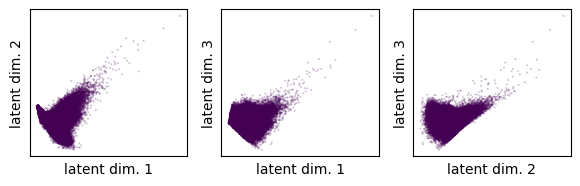

In [50]:
embedding_method = 'pca'

embeddings[embedding_method] = embedders[embedding_method].fit_transform(
    pd.DataFrame(
        map_data.line_intensities.get('sum')
    ).drop(columns=['266.08'])
)

fig = plot_embedding(
    embeddings[embedding_method],
    # explained_variances=pca_model.explained_variance_ratio_.copy(),
    # colors=predicted_labels[clustering_method],
    marker_size=2,
    return_figure=True
)
# fig.suptitle(clustering_method)
fig.patch.set_alpha(0)
fig.tight_layout()
# fig.savefig(
#     f'./temp/{embedding_method}_embeddings_full_spectra_clustering_using_{clustering_method}_{segment}',
#     transparent=True
# )

# from joblib import load
# pca_model = load('../temp/pca_model.joblib')

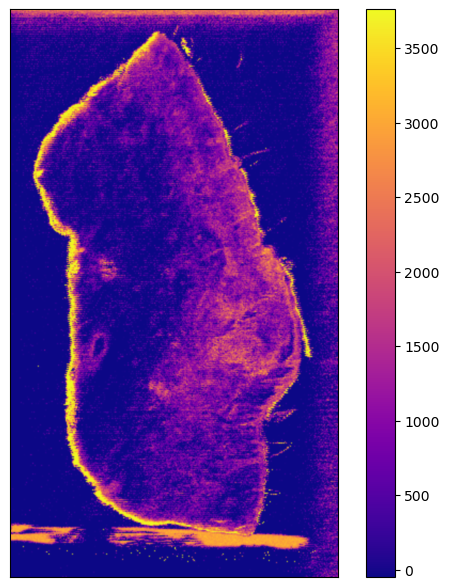

In [106]:
plot_data = map_data.vector_to_array(embeddings['pca'][:,1])
plot_single_variable_map(
    plot_data,
    fig_size_scaling=2
)

# Edge detection

In [53]:
import cv2

In [86]:
# map_data._line_intensities_to_arrays()

converting line intensities to arrays


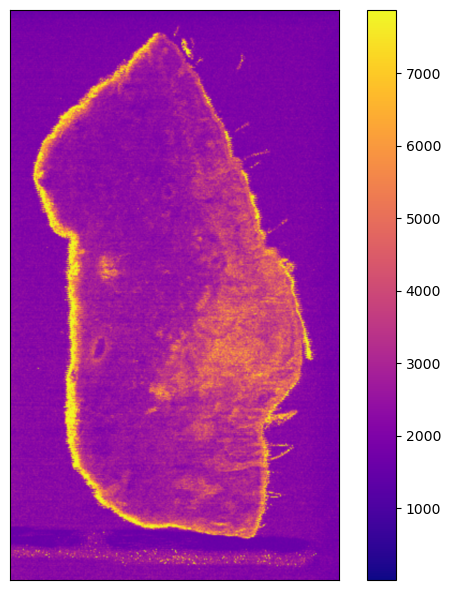

In [127]:
# edge_data = map_data.vector_to_array(embeddings['pca'][:,1])
# edge_data = map_data.vector_to_array(line_ratios['sum']['div_by_279.63']['393.34/279.63'])
edge_data = map_data.vector_to_array(map_data.line_intensities['sum']['393.34'])
plot_single_variable_map(
    edge_data,
    fig_size_scaling=2
)


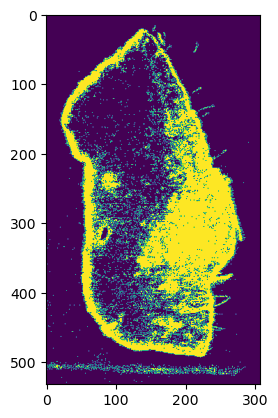

In [142]:
# edge_data = map_data.vector_to_array(embeddings['pca'][:,1])
edge_data = map_data.vector_to_array(map_data.line_intensities['sum']['393.34'])
edge_data -= edge_data.min()
edge_data /= edge_data.max()
edge_data *= 255
edge_data = edge_data.astype(np.uint8)

th, im_th = cv2.threshold(
    edge_data, 
    10,
    230,
    cv2.THRESH_BINARY
)
plt.imshow(im_th)

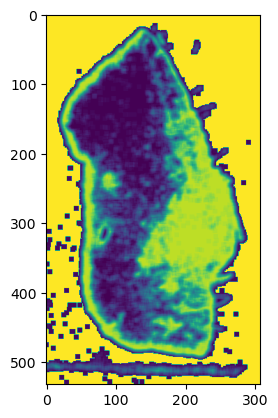

In [145]:
# Copy the thresholded image.
im_floodfill = im_th.copy()

im_floodfill = cv2.filter2D(
    im_floodfill, 
    -1, 
    np.ones(shape=(7,7))/49
    # np.ones(shape=(20,20))/400
)
  
# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
  
# # Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255)
plt.imshow(im_floodfill)

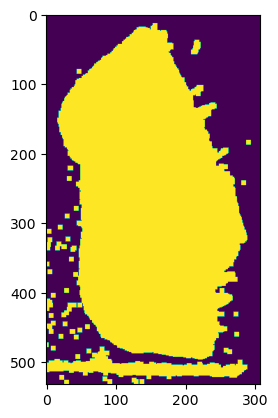

In [146]:
plt.imshow(im_floodfill != 255)

In [105]:
(im_floodfill != 255).reshape(-1,1)

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [147]:
kept_spectra_ratio = np.sum(im_floodfill != 255)\
  /(im_floodfill.shape[0] * im_floodfill.shape[1])
print(f'{kept_spectra_ratio:.2f}')

0.60


In [151]:
cluster_data = map_data.spectra[(im_floodfill != 255).reshape(-1),:]

In [153]:
reduced_embeddings = embedders['pca'].fit_transform(
    cluster_data
)

c:\Users\kepes\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



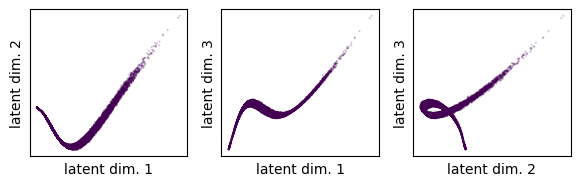

In [154]:
fig = plot_embedding(
    reduced_embeddings,
    marker_size=2,
    return_figure=True
)
fig.patch.set_alpha(0)
fig.tight_layout()

In [168]:
plot_data = np.zeros(map_data.spectra.shape[0])
plot_data[(im_floodfill != 255).reshape(-1)] = reduced_embeddings[:,0]

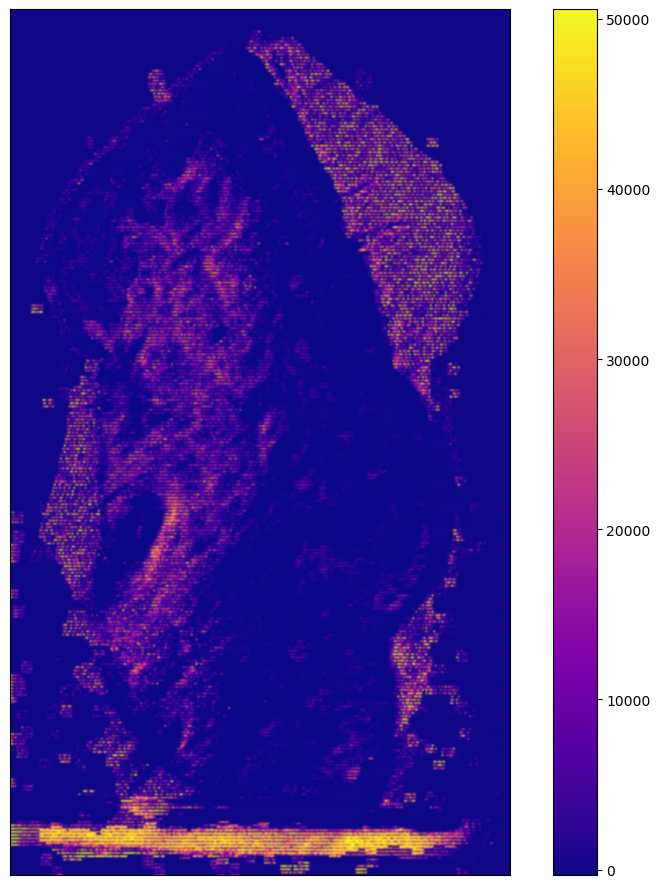

In [170]:
plot_single_variable_map(
    map_data.vector_to_array(plot_data),
    fig_size_scaling=3
)

In [ ]:
embedding_method = 'umap'
image_data = np.concatenate([
    map_data.vector_to_array(
        embeddings[embedding_method][:,0]
    )[...,np.newaxis],
    map_data.vector_to_array(
        embeddings[embedding_method][:,1]
    )[...,np.newaxis],
    map_data.vector_to_array(
        embeddings[embedding_method][:,2]
    )[...,np.newaxis]],
    axis=2
)

image_data -= image_data.min()
image_data /= image_data.max()

plt.figure(figsize=(9,9))
plt.imshow(
    image_data
)

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        y=maxima_spectrum
    )
)

# Autocorrelation

In [ ]:
import statsmodels.api as sm

x = maxima_spectrum[3500:3600].copy()
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        y=x
    )
)

# Plot the correlogram
sm.graphics.tsa.plot_acf(x, lags=99)
plt.show()

In [ ]:
pd.plotting.autocorrelation_plot(x)

In [ ]:
def get_autocorrelation(x):
    x = x.copy()
    x -= np.mean(x)
    autocorrelation = np.correlate(x,x,mode='full')
    autocorrelation /= np.var(x)
    return autocorrelation[len(autocorrelation)//2:]

In [ ]:
data = np.apply_along_axis(
    func1d=get_autocorrelation,
    axis=1,
    arr=map_data.spectra[:,3500:3600]
)

In [ ]:
def get_extremum_locations(x):
    maxima = np.where(np.diff(np.sign(np.diff(x))) == -2)[0] + 1
    minima = np.where(np.diff(np.sign(np.diff(x))) == 2)[0] + 1
    return (maxima, minima)

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        y=get_autocorrelation(map_data.spectra[0,3500:3600])
        # y=data[0]
    )
)


In [ ]:
extremum_locations = [
    get_extremum_locations(x)
    for x
    in data
]

In [ ]:
plot_data = np.zeros(len(extremum_locations))
for ndx in range(len(plot_data)):
    try:
        plot_data[ndx] = extremum_locations[ndx][0][0]
    except IndexError:
        pass

plot_single_variable_map(
    map_data.vector_to_array(plot_data),
    fig_size_scaling=3
)

In [ ]:
print(np.where(np.diff(np.sign(np.diff(autocorrelation))) == -2)[0] + 1)
print(np.where(np.diff(np.sign(np.diff(autocorrelation))) == 2)[0] + 1)

In [ ]:
np.diff(np.where(np.diff(np.sign(np.diff(autocorrelation))) == 2)[0])

In [ ]:
autocorrelation[np.where(np.diff(np.sign(np.diff(autocorrelation))) == -2)[0] + 1]
autocorrelation[np.where(np.diff(np.sign(np.diff(autocorrelation))) == 2)[0] + 1]